In [1]:
import sys, os
sys.path.append("../model/")
sys.path.append("../datasets/")
from PFINDataset import PFINDataset
from UQPFIN import UQPFIN as Model
from train import getprobs
from EvalTools import *
import numpy as np
import torch
from torch.utils.data import DataLoader
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import json
from scipy import interpolate
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
#import mpl_scatter_density
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
#optional parameters to only evaluate certain models
dataset = 'topdata'
optional_tag = 'nominal_1.0_baseline'
results_dir = 'results/'
saved_model_loc = "../model/trained_models/"
saved_model_dict_loc = "../model/trained_model_dicts/"

result_files = sorted([f for f in os.listdir(results_dir) if dataset in f and optional_tag in f
                      and "Ensemble" not in f and "MCDO" not in f and '.h5' in f])
print('\n'.join(result_files))

RESULTS_UQPFIN_best_topdata_nominal_1.0_baseline.h5


In [3]:
if dataset == 'topdata':
    true_classes = [0, 1] # 0:QCD, 1:top
    names = ["background", "signal"]
if dataset == 'jetnet':
    true_classes = [0, 1, 2, 3, 4] # 0: g, 1:q, 2:t, 3:w, 4:z
    names = ['light quarks', 'gluons', 'top quarks', 'W bosons', 'Z bosons']
if dataset == 'jetclass':
    true_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # 0: g, 1:q, 2:t, 3:w, 4:z
    names = ['l_QCD', 'l_Hbb', 'l_Hcc', 'l_Hgg', 'l_H4q', 'l_Hqql', 'l_Zqq', 'l_Wqq', 'l_Tbqq', 'l_Tbl']
if dataset == 'JNqgmerged':
    true_classes = [0, 1, 2, 3] # 0: g/q, 1:t, 2:w, 3:z
    names = ['QCD', 'top quarks', 'W bosons', 'Z bosons']

In [4]:
model_results = {}

for modelname in result_files:
    mname = modelname[20:-3]
    print(mname)
    filename = os.path.join(results_dir, modelname)
    
    f = h5py.File(filename, "r")
    model_results[mname] = {'labels' : f['labels'][:], 
                               'preds': f['preds'][:], 
                               'maxprobs': f['maxprobs'][:],
                               'sums':f['sums'][:], 
                               'oods':f['oods'][:],
                               'uncs': f['uncs'][:],
                               'probs': f['probs'][:],
                               'latents': f['latents'][:],
                               'aug': f['aug'][:]}
    f.close()

topdata_nominal_1.0_baseline


In [5]:
all_keys = list(model_results.keys())
all_keys

['topdata_nominal_1.0_baseline']

topdata_nominal_1.0_baseline


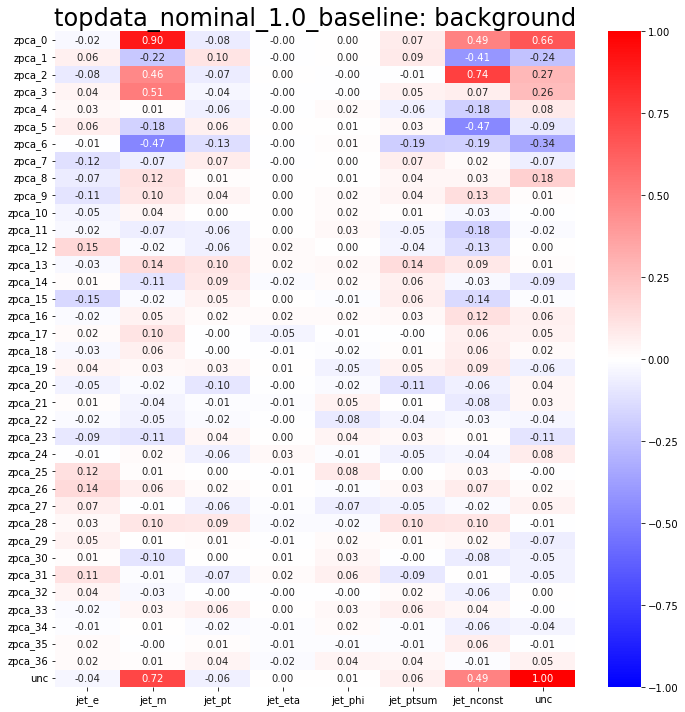

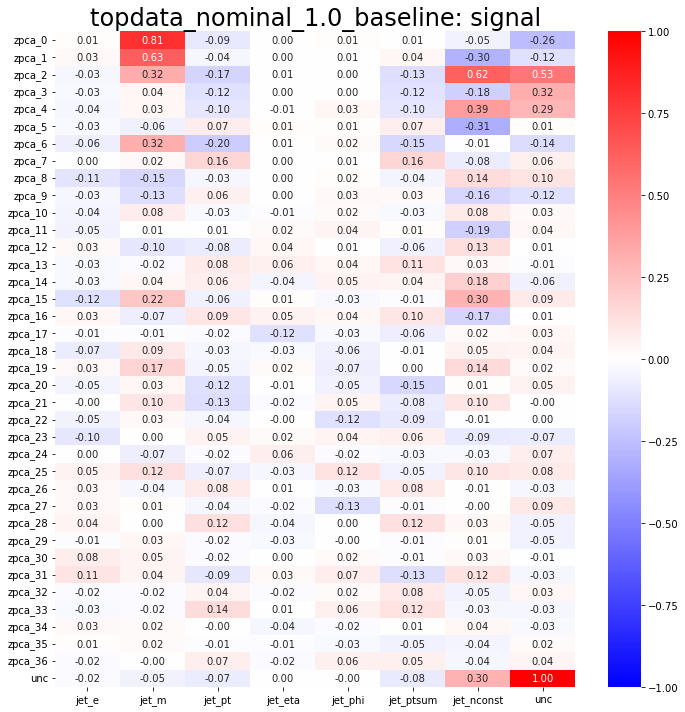

In [6]:
aug_cols = ['jet_e', 'jet_m', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_ptsum', 'jet_nconst', 'unc']

for ii,key in enumerate(np.sort(all_keys)):
    
    model2explore = key
    print(key)
    labels, aug, uncs, latents = model_results[model2explore]['labels'], model_results[model2explore]['aug'], \
                                   model_results[model2explore]['uncs'],   model_results[model2explore]['latents']
    uncs = uncs[..., np.newaxis]
    
    pca = PCA(n_components=0.99)
    pca.fit(latents)
    for i in range(len(names)):
        indices = labels == i
    
        latents_pca = pca.fit_transform(latents)
        
        n_latents = latents_pca.shape[1]
        n_latents = latents_pca.shape[1]
        pca_cols = ["zpca_{}".format(i) for i in range(n_latents)]
        df_pca = pd.DataFrame(latents_pca[indices, :n_latents], columns = pca_cols)
        df_aug = pd.DataFrame(np.append(aug[indices], uncs[indices], axis=1), columns = aug_cols)
        df_pca_cols = df_pca.columns.tolist()
        df_pca_cols.append("unc")
        corrmat = pd.concat([df_pca, df_aug], axis=1).corr().loc[df_pca_cols, df_aug.columns]
        plt.figure(figsize=(10,10))
        sns.heatmap(corrmat, annot = True, cmap='bwr', fmt='.2f',vmin= -1., vmax = 1.)
        plt.title(key + ": " + names[i], fontsize=24)
        plt.tight_layout()
        #plt.savefig("corr_matrices/"+key+"_class_" + names[i] + "_corr.pdf", dpi=600)
        plt.show()